# Stripe and Artifact Removal using Fourier Space Inpainting

This notebook implements the stripe removal algorithm from the paper "Removing Stripes, Scratches, and Curtaining with Non-Recoverable Compressed Sensing".

The process is as follows:
1.  **Fourier Transform**: The image is converted to the frequency domain.
2.  **Masking**: The artifact data is masked (removed).
3.  **Iterative Recovery**: A compressed sensing technique called Total Variation (TV) Minimization is used to intelligently "inpaint" the missing data in the Fourier domain.
4.  **Inverse Transform**: The recovered frequency data is transformed back into an image, resulting in a clean, de-striped output.

In [4]:
import os
import numpy as np
from skimage import io, util
from matplotlib import pyplot as plt
from tqdm import tqdm
from PIL import Image
import torch
import pyiqa
import csv
from skimage.metrics import peak_signal_noise_ratio
import pandas as pd

# Setup device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# This is the most important step: import the `destripe` class from the destripe.py file.
from destripe import destripe

print("Setup complete. The 'destripe' class has been successfully imported.")

Using device: cuda
Setup complete. The 'destripe' class has been successfully imported.


## Run the De-striping Algorithm

1.  **Set the `INPUT_FOLDER_PATH` and `OUTPUT_FOLDER_PATH`** to the images to clean (either .png or .DCM).
2.  **Show the Fourier Transform**: Will show the fourier transofmr of some of the images to identify the problematic regions.
3.  **Adjust the parameters**:
    -   `stripe_width`: The most important parameter. It's the thickness of the line to remove in the Fourier domain. You will need to experiment to find the best value. Start small (e.g., 5-10).
    -   `stripe_angle`: For your vertical lines, this should be `0`.
    -   `iterations`: The number of recovery iterations. 10 is usually a good range for speed vs efficiency
4.  **Run the cell**. It will display some of the original and de-striped images.

In [14]:
# --- Configuration for Batch Processing ---
#INPUT_FOLDER = 'C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/LODOX_Scans'
INPUT_FOLDER = 'C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Stripy_Images_NRCS'
OUTPUT_FOLDER = 'C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Destriped_Images_NRCS'
RESULTS_CSV_FILE = 'NRCS.csv'

# --- Parameters ---
wedgeSize = 20
a = 0.01
niter = 2
theta = 0
kmin = 15
# ----------------------------------------

# --- Control Flags ---
save_images = 1 # Set to True to save destriped images
calculate_iqa = True # Set to True to calculate IQA scores (requires pyiqa and torch)
# --------------------

In [15]:
# Create IQA metric models (do this once outside the loop)
metrics_available = False

if calculate_iqa:
    try:
        niqe_metric = pyiqa.create_metric('niqe', device=device)
        piqe_metric = pyiqa.create_metric('piqe', device=device)
        brisque_metric = pyiqa.create_metric('brisque', device=device)
        metrics_available = True
        print("IQA metrics (NIQE, PIQE, BRISQUE) created successfully.")
    except Exception as e:
        metrics_available = False
        print(f"Warning: Could not create IQA metrics. Set calculate_iqa=False or install pyiqa and torch. Error: {e}")
        print("Skipping IQA score calculation.")
else:
    print("Skipping IQA score calculation as requested.")
# ---------------------

# --- Prepare CSV file for results ---
csv_rows = [] # Store rows in memory first
csv_header = [
    'Filename', 'WedgeSize', 'Niter', 'a', 'Kmin', 'Theta',
    'Input_PIQE', 'Input_BRISQUE', 'Input_NIQE',
    'Output_PIQE', 'Output_BRISQUE', 'Output_NIQE', 'PSNR'
]
csv_rows.append(csv_header)

IQA metrics (NIQE, PIQE, BRISQUE) created successfully.


In [16]:
# --- Begin Batch Processing ---
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
all_files = [f for f in os.listdir(INPUT_FOLDER) if f.lower().endswith(('.png', '.dcm', '.jpg', '.jpeg', '.tif', '.tiff'))]
print(f"Found {len(all_files)} images to process.")

for filename in tqdm(all_files, desc="Processing Images"):
    input_path = os.path.join(INPUT_FOLDER, filename)
    base, ext = os.path.splitext(filename)
    output_filename = f"{base}_w{wedgeSize}_n{niter}_a{a}_k{kmin}_th{theta}_{ext}"
    output_path = os.path.join(OUTPUT_FOLDER, output_filename)

    try:
        # Load image safely
        input_img = io.imread(input_path, as_gray=True)
        input_img = np.array(input_img, dtype=np.float32)

        # --- Run destriping ---
        destripe_obj = destripe(input_img, niter, a, wedgeSize, theta, kmin, output_path)
        destripe_obj.TV_reconstruction(save=save_images)
        recon_img = destripe_obj.recon

        # Sanitize reconstructed image
        recon_img = np.nan_to_num(recon_img, nan=0.0, posinf=np.max(input_img), neginf=0.0)
        recon_img = np.clip(recon_img, 0, np.max(input_img))

        # Safe copy for IQA only
        iqa_input = np.clip(input_img / np.max(input_img), 0, 1)
        iqa_recon = np.clip(recon_img / np.max(recon_img), 0, 1)

        # --- Compute IQA Metrics ---
        input_piqe = input_brisque = input_niqe = float('nan')
        output_piqe = output_brisque = output_niqe = float('nan')
        psnr_value = float('nan')

        if metrics_available:
            # Skip if image is too flat
            if np.std(iqa_input) > 1e-3 and np.std(iqa_recon) > 1e-3:
                input_tensor = torch.tensor(iqa_input).unsqueeze(0).unsqueeze(0).to(device)
                output_tensor = torch.tensor(iqa_recon).unsqueeze(0).unsqueeze(0).to(device)

                try:
                    input_piqe = piqe_metric(input_tensor).item()
                except Exception as e:
                    print(f"⚠️ PIQE failed for {filename}: {e}")

                try:
                    input_brisque = brisque_metric(input_tensor).item()
                except Exception as e:
                    print(f"⚠️ BRISQUE failed for {filename}: {e}")

                try:
                    input_niqe = niqe_metric(input_tensor).item()
                except Exception as e:
                    print(f"⚠️ NIQE failed for {filename}: {e}")

                try:
                    output_piqe = piqe_metric(output_tensor).item()
                except Exception as e:
                    print(f"⚠️ PIQE (output) failed for {filename}: {e}")

                try:
                    output_brisque = brisque_metric(output_tensor).item()
                except Exception as e:
                    print(f"⚠️ BRISQUE (output) failed for {filename}: {e}")

                try:
                    output_niqe = niqe_metric(output_tensor).item()
                except Exception as e:
                    print(f"⚠️ NIQE (output) failed for {filename}: {e}")

                try:
                    psnr_value = peak_signal_noise_ratio(iqa_input, iqa_recon, data_range=1.0)
                except Exception as e:
                    print(f"⚠️ PSNR computation failed for {filename}: {e}")
            else:
                print(f"Skipping IQA for {filename} (image too flat)")
        else:
            print("Skipping IQA (metrics unavailable).")

        # --- Save results to CSV memory ---
        csv_rows.append([
            filename, wedgeSize, niter, a, kmin, theta,
            input_piqe, input_brisque, input_niqe,
            output_piqe, output_brisque, output_niqe, psnr_value
        ])

    except Exception as e:
        print(f"❌ Error processing {filename}: {e}")
# --- End Batch Processing ---

# Save CSV
# with open(RESULTS_CSV_FILE, mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerows(csv_rows)
# print(f"\n✅ Processing complete. Results saved to {RESULTS_CSV_FILE}")

Found 22 images to process.


Processing Images:   0%|                                                                        | 0/22 [00:00<?, ?it/s]

Image saved to: C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Destriped_Images_NRCS\Avo_w20_n2_a0.01_k15_th0__destriped.png


Processing Images:   5%|██▉                                                             | 1/22 [00:04<01:42,  4.87s/it]

Image saved to: C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Destriped_Images_NRCS\Cabbage Infant_w20_n2_a0.01_k15_th0__destriped.png


Processing Images:   9%|█████▊                                                          | 2/22 [00:09<01:33,  4.66s/it]

Image saved to: C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Destriped_Images_NRCS\Cabbage Large_w20_n2_a0.01_k15_th0__destriped.png


Processing Images:  14%|████████▋                                                       | 3/22 [00:13<01:26,  4.56s/it]

Image saved to: C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Destriped_Images_NRCS\Cabbage Med_w20_n2_a0.01_k15_th0__destriped.png


Processing Images:  18%|███████████▋                                                    | 4/22 [00:18<01:20,  4.49s/it]

Image saved to: C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Destriped_Images_NRCS\Cabbage Ped_w20_n2_a0.01_k15_th0__destriped.png


Processing Images:  23%|██████████████▌                                                 | 5/22 [00:22<01:17,  4.54s/it]

Image saved to: C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Destriped_Images_NRCS\Cabbage Small_w20_n2_a0.01_k15_th0__destriped.png


Processing Images:  27%|█████████████████▍                                              | 6/22 [00:27<01:12,  4.54s/it]

Image saved to: C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Destriped_Images_NRCS\Cabbage XL_w20_n2_a0.01_k15_th0__destriped.png


Processing Images:  32%|████████████████████▎                                           | 7/22 [00:31<01:07,  4.51s/it]

Image saved to: C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Destriped_Images_NRCS\Cabbage_w20_n2_a0.01_k15_th0__destriped.png


Processing Images:  36%|███████████████████████▎                                        | 8/22 [00:36<01:03,  4.57s/it]

Image saved to: C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Destriped_Images_NRCS\Citrus_w20_n2_a0.01_k15_th0__destriped.png


Processing Images:  41%|██████████████████████████▏                                     | 9/22 [00:41<00:59,  4.55s/it]

Image saved to: C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Destriped_Images_NRCS\Egg_w20_n2_a0.01_k15_th0__destriped.png


Processing Images:  45%|████████████████████████████▋                                  | 10/22 [00:45<00:54,  4.50s/it]

Image saved to: C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Destriped_Images_NRCS\Garlic_w20_n2_a0.01_k15_th0__destriped.png


Processing Images:  50%|███████████████████████████████▌                               | 11/22 [00:49<00:49,  4.47s/it]

Image saved to: C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Destriped_Images_NRCS\Lemon_w20_n2_a0.01_k15_th0__destriped.png


Processing Images:  55%|██████████████████████████████████▎                            | 12/22 [00:54<00:44,  4.44s/it]

Image saved to: C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Destriped_Images_NRCS\Papaya_w20_n2_a0.01_k15_th0__destriped.png


Processing Images:  59%|█████████████████████████████████████▏                         | 13/22 [00:58<00:40,  4.49s/it]

Image saved to: C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Destriped_Images_NRCS\Peppers_w20_n2_a0.01_k15_th0__destriped.png


Processing Images:  64%|████████████████████████████████████████                       | 14/22 [01:03<00:35,  4.46s/it]

Image saved to: C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Destriped_Images_NRCS\Pineapple 2_w20_n2_a0.01_k15_th0__destriped.png


Processing Images:  68%|██████████████████████████████████████████▉                    | 15/22 [01:07<00:31,  4.51s/it]

Image saved to: C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Destriped_Images_NRCS\Pineapple Infant_w20_n2_a0.01_k15_th0__destriped.png


Processing Images:  73%|█████████████████████████████████████████████▊                 | 16/22 [01:12<00:27,  4.65s/it]

Image saved to: C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Destriped_Images_NRCS\Pineapple Large_w20_n2_a0.01_k15_th0__destriped.png


Processing Images:  77%|████████████████████████████████████████████████▋              | 17/22 [01:17<00:23,  4.70s/it]

Image saved to: C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Destriped_Images_NRCS\Pineapple Med_w20_n2_a0.01_k15_th0__destriped.png


Processing Images:  82%|███████████████████████████████████████████████████▌           | 18/22 [01:22<00:19,  4.85s/it]

Image saved to: C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Destriped_Images_NRCS\Pineapple Ped_w20_n2_a0.01_k15_th0__destriped.png


Processing Images:  86%|██████████████████████████████████████████████████████▍        | 19/22 [01:27<00:14,  4.83s/it]

Image saved to: C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Destriped_Images_NRCS\Pineapple Small_w20_n2_a0.01_k15_th0__destriped.png


Processing Images:  91%|█████████████████████████████████████████████████████████▎     | 20/22 [01:32<00:09,  4.89s/it]

Image saved to: C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Destriped_Images_NRCS\Pineapple_w20_n2_a0.01_k15_th0__destriped.png


Processing Images:  95%|████████████████████████████████████████████████████████████▏  | 21/22 [01:37<00:04,  4.92s/it]

Image saved to: C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Destriped_Images_NRCS\Tomato_w20_n2_a0.01_k15_th0__destriped.png


Processing Images: 100%|███████████████████████████████████████████████████████████████| 22/22 [01:42<00:00,  4.66s/it]


In [17]:
# # --- Configuration for Batch Processing ---
# #INPUT_FOLDER = 'C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/LODOX_Scans'
# INPUT_FOLDER = 'C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Final/NRCS_In'
# OUTPUT_FOLDER = 'C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Final/NRCS_Out'

# # --- Use the Optimal Parameters You Found ---
# wedgeSize = 5
# a = 0.01
# niter = 10
# theta = 0
# kmin = 15
# save = 1 # Use 1 for True, 0 for False (as originally seemed intended)
# # ----------------------------------------

# # --- Essential Imports ---
# import os
# import numpy as np
# from skimage import io
# from tqdm import tqdm
# # Assuming 'destripe.py' and 'FFTW.py' are in the same directory or Python path
# from destripe import destripe
# # ------------------------

# os.makedirs(OUTPUT_FOLDER, exist_ok=True)
# # Original code only looked for .png, let's keep it that way unless you need others
# all_files = [f for f in os.listdir(INPUT_FOLDER) if f.lower().endswith('.png')]
# print(f"Found {len(all_files)} images to process.")

# # --- Loop through each file, process it, and save the result ---
# for i, filename in enumerate(tqdm(all_files, desc="Processing Images")):
#     input_path = os.path.join(INPUT_FOLDER, filename)
#     # Pass the intended *output* path stub to the destripe class 'fname' parameter.
#     # The class will add '_destriped' before saving if save=True.
#     output_path_stub_for_fname = os.path.join(OUTPUT_FOLDER, filename)

#     try:
#         # Load image as grayscale numpy array (original didn't normalize here)
#         input_img = io.imread(input_path, as_gray=True)
#         # Original conversion to float32
#         input_img = np.array(input_img, dtype=np.float32)

#         # Create an instance of the destripe object.
#         destripe_obj = destripe(input_img, niter, a, wedgeSize, theta, kmin, fname=output_path_stub_for_fname) # Use fname parameter

#         # Run the reconstruction. Pass the save flag.
#         # The TV_reconstruction method will now handle saving based on its internal logic and the fname provided.
#         destripe_obj.TV_reconstruction(save=bool(save)) # Convert 1/0 to True/False

#     except Exception as e:
#         print(f"\nCould not process {filename}. Error: {e}")

# print("\n--- Batch processing complete. ---")

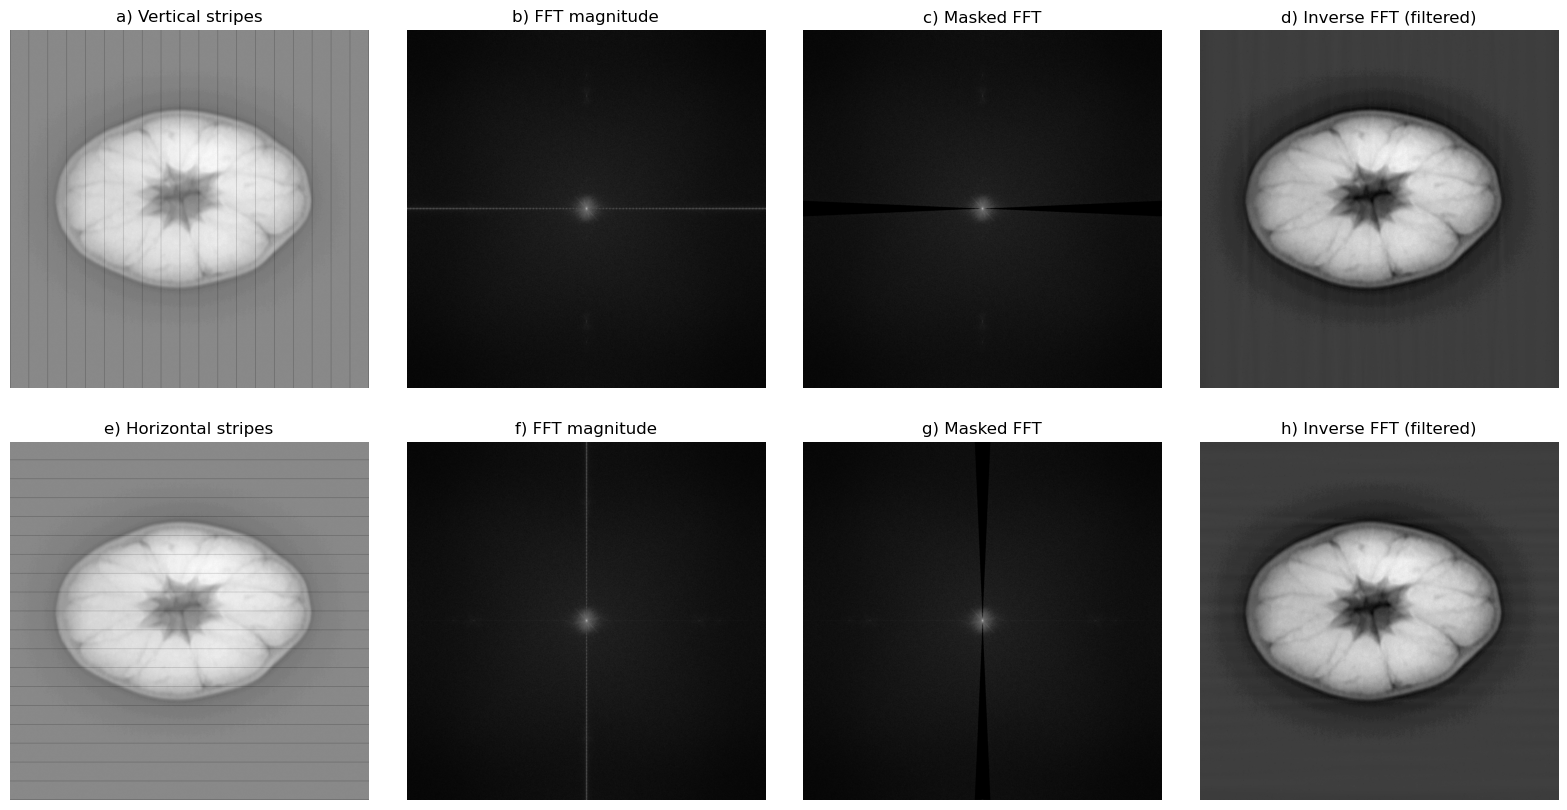

In [52]:
# import numpy as np
# from PIL import Image
# import matplotlib.pyplot as plt

# # --- Function to add thin stripes ---
# # def add_thin_stripes(img, orientation='vertical', n_stripes=20, stripe_intensity=0.05):
# #     """
# #     Add very thin black/gray lines to an image.
    
# #     Parameters:
# #     - img : 2D array, grayscale image normalized [0,1]
# #     - orientation : 'vertical' or 'horizontal'
# #     - n_stripes : number of stripes
# #     - stripe_intensity : how dark the stripes are (0 = no change, 1 = black)
# #     """
# #     img_with_stripes = img.copy()
# #     nx, ny = img.shape[:2]

# #     if orientation == 'vertical':
# #         stripe_positions = np.linspace(0, ny-1, n_stripes, dtype=int)
# #         for x in stripe_positions:
# #             img_with_stripes[:, x] *= (1 - stripe_intensity)  # darken the stripe
# #     else:
# #         stripe_positions = np.linspace(0, nx-1, n_stripes, dtype=int)
# #         for y in stripe_positions:
# #             img_with_stripes[y, :] *= (1 - stripe_intensity)

# #     return img_with_stripes
# def add_thin_black_stripes(img, orientation='vertical', n_stripes=20):
#     """
#     Add very thin black lines to an image.

#     Parameters:
#     - img : 2D array, grayscale normalized [0,1]
#     - orientation : 'vertical' or 'horizontal'
#     - n_stripes : number of stripes across the image
#     """
#     img_with_stripes = img.copy()
#     nx, ny = img.shape[:2]

#     if orientation == 'vertical':
#         stripe_positions = np.linspace(0, ny-1, n_stripes, dtype=int)
#         for x in stripe_positions:
#             img_with_stripes[:, x] = 0  # 1-pixel black line
#     else:
#         stripe_positions = np.linspace(0, nx-1, n_stripes, dtype=int)
#         for y in stripe_positions:
#             img_with_stripes[y, :] = 0  # 1-pixel black line

#     return img_with_stripes

# # --- Load your 2048x2048 image ---
# base_img_path = r'C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Cropped_Dataset_2048x2048/UB Fruit medium.png'
# img = Image.open(base_img_path).convert('L')  # grayscale
# img = np.array(img, dtype=np.float32) / 255.0  # normalize [0,1]

# # --- Add subtle stripes ---
# img_vert = add_thin_stripes(img, orientation='vertical', n_stripes=20, stripe_intensity=0.5)
# img_horiz = add_thin_stripes(img, orientation='horizontal', n_stripes=20, stripe_intensity=0.5)

# # --- Destripe setup ---
# wedgeSize = 5
# kmin = 15

# # Replace this with your destripe class import
# # from destripe import destripe  

# d_vert = destripe(dataset=img_vert, Niter=5, a=0.01, wedgeSize=wedgeSize, theta=0, kmin=kmin, fname=None)
# d_horiz = destripe(dataset=img_horiz, Niter=5, a=0.01, wedgeSize=wedgeSize, theta=90, kmin=kmin, fname=None)

# # --- Compute FFTs ---
# fft_vert = np.fft.fftshift(d_vert.fftw.fft(img_vert))
# fft_horiz = np.fft.fftshift(d_horiz.fftw.fft(img_horiz))

# fft_mag_vert = np.log(np.abs(fft_vert) + 1)
# fft_mag_horiz = np.log(np.abs(fft_horiz) + 1)

# # --- Create masks ---
# mask_vert = d_vert.create_mask()
# mask_horiz = d_horiz.create_mask()

# # --- Apply masks ---
# fft_masked_vert = fft_vert * mask_vert
# fft_masked_horiz = fft_horiz * mask_horiz

# # --- Inverse FFTs ---
# img_recon_vert = np.real(d_vert.fftw.ifft(np.fft.ifftshift(fft_masked_vert)))
# img_recon_horiz = np.real(d_horiz.fftw.ifft(np.fft.ifftshift(fft_masked_horiz)))

# # --- Plot results ---
# fig, axes = plt.subplots(2, 4, figsize=(20, 10))
# plt.subplots_adjust(wspace=0.1, hspace=0.15)

# titles = [
#     ["a) Vertical stripes", "b) FFT magnitude", "c) Masked FFT", "d) Inverse FFT (filtered)"],
#     ["e) Horizontal stripes", "f) FFT magnitude", "g) Masked FFT", "h) Inverse FFT (filtered)"]
# ]

# for row, (img_input, fft_img, fft_masked, img_recon) in enumerate(
#     [(img_vert, fft_mag_vert, fft_masked_vert, img_recon_vert),
#      (img_horiz, fft_mag_horiz, fft_masked_horiz, img_recon_horiz)]
# ):
#     axes[row, 0].imshow(img_input, cmap='gray')
#     axes[row, 0].set_title(titles[row][0])
#     axes[row, 0].axis('off')

#     axes[row, 1].imshow(fft_img, cmap='gray')
#     axes[row, 1].set_title(titles[row][1])
#     axes[row, 1].axis('off')

#     axes[row, 2].imshow(np.log(np.abs(fft_masked) + 1), cmap='gray')
#     axes[row, 2].set_title(titles[row][2])
#     axes[row, 2].axis('off')

#     axes[row, 3].imshow(img_recon, cmap='gray')
#     axes[row, 3].set_title(titles[row][3])
#     axes[row, 3].axis('off')

# plt.savefig("destripe_results.pdf", format='pdf', bbox_inches='tight', dpi=300)
# plt.show()